# OBJECTIF

- Wavelet:
    - trouver une famille d'ondelettes sur laquelle décomposer les ECG
    - paramètres:
        - level
        - famille + numéro
        - threshold coefficients
    - critères:
        - SNR (comparaison ECG original - ECG reconstruit)
        - PCA (sur les ECG de tous les patients)

In [1]:
import h5py
import pywt
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
import get_ecg
import utils.load as ul
import utils.illustration as uil

In [3]:
LEN=4096
NB_PATIENT=827
TRACINGS_FILE="./data/ecg_tracings.hdf5"

# Données

Test pour patient non malade

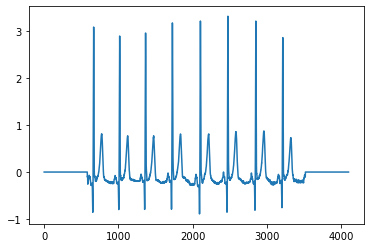

In [4]:
ecg_example=get_ecg.get_ecg()[0]
plt.plot(ecg_example)

In [5]:
with h5py.File(TRACINGS_FILE, "r") as f:
    table_ecg = np.array(f['tracings'])
    ECG_0=table_ecg[:,:,0]
print(np.shape(ECG_0))

(827, 4096)


# 1.  Décomposition Wavelet

In [12]:
pywt.families(short=False)

['Haar',
 'Daubechies',
 'Symlets',
 'Coiflets',
 'Biorthogonal',
 'Reverse biorthogonal',
 'Discrete Meyer (FIR Approximation)',
 'Gaussian',
 'Mexican hat wavelet',
 'Morlet wavelet',
 'Complex Gaussian wavelets',
 'Shannon wavelets',
 'Frequency B-Spline wavelets',
 'Complex Morlet wavelets']

Nous étudierons la décomposition des signaux ECG au travers de 2 familles d'ondelette :
- Daubechies : 4, 5, 6, 7
- Symlets : 5, 6, 7, 8

avec plusieurs niveaux de décomposition.

## Exemple : db5

[ 0.          0.22641898  0.85394354  1.02432694  0.19576696 -0.34265672
 -0.04560113  0.10970266 -0.0088268  -0.01779187  0.00471743  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[ 0.          0.00471743  0.01779187 -0.0088268  -0.10970266 -0.04560113
  0.34265672  0.19576696 -1.02432694  0.85394354 -0.22641898  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8.  8.5
 9. ]


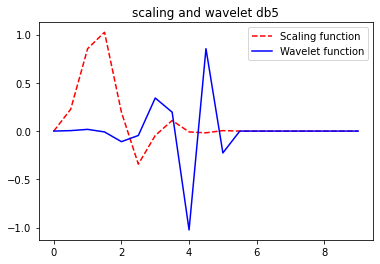

In [13]:
wavelet = pywt.Wavelet('db5')
phi, psi, x = wavelet.wavefun(level=1)
print (phi)
print(psi)
print(x)
p1,=plt.plot(x,phi,'r--')
p2,=plt.plot(x,psi,'b-')
plt.title("scaling and wavelet db5")
plt.legend([p1, p2], ['Scaling function', 'Wavelet function'])
plt.show()

### Level

In [14]:
print("niveau maximal de décomposition")
w = pywt.Wavelet('db5')
pywt.dwt_max_level(4096, w)

niveau maximal de décomposition


8

### Single-level decomposition

In [15]:
cA, cD = pywt.dwt(ecg_example, 'db5')

#  Approximation (or scale) coefficients 
print(cA)
# Detail (or wavelets) coefficients
print(cD)

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


### Multi-level decomposition

In [16]:
coeffs = pywt.wavedec(ecg_example, 'db5',level=3)

cA3, cD3, cD2 , cD1 = coeffs

print("cA3",cA3)
print("cD3",cD3)
print("cD2",cD2)
print("cD1",cD1)

cA3 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.0

### Thresholding (pour méthode d'approximation  non linéaire)

In [17]:
sigma=1

thresh = sigma*np.sqrt(2*np.log(LEN))

sigma =  1
Number of non-zero coefficients before =  2944
Number of non-zero coefficients after =  1472


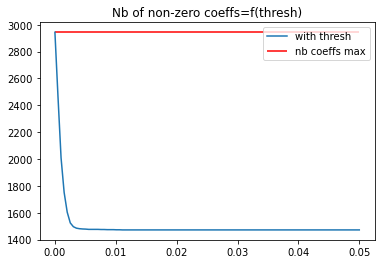

In [18]:
#single-level
cDth=pywt.threshold(cD, thresh, 'hard')

nbcoef1=sum(cA!=0)+sum(cD!=0)
nbcoef2=sum(cA!=0)+sum(cDth!=0)

print('sigma = ', 1)
print ('Number of non-zero coefficients before = ', nbcoef1)
print ('Number of non-zero coefficients after = ', nbcoef2)

def test_threshold_single_level(ecg,sigma_min=0, sigma_max=0.05, family='db5'):
    cA,cD = pywt.dwt(ecg, family)
    plt.hlines(sum(cA!=0)+sum(cD!=0),sigma_min, sigma_max, label='nb coeffs max', color='red')
    
    sigma_space=np.linspace(sigma_min,sigma_max,100)
    nbcoef_after=[]
    
    for sigma in sigma_space:
        thresh = sigma*np.sqrt(2*np.log(LEN))
        cA,cD = pywt.dwt(ecg, family)
        
        cDth=pywt.threshold(cD, thresh, 'hard')
        nbcoef_after.append(sum(cA!=0)+sum(cDth!=0))
    plt.plot(sigma_space,nbcoef_after, label='with thresh')
    plt.title("Nb of non-zero coeffs=f(thresh)")
    plt.legend()
    plt.show()

test_threshold_single_level(ecg_example)
        
    

sigma =  1
Number of non-zero coefficients before =  2962
Number of non-zero coefficients after =  375


C:\Users\maxen\Anaconda3\lib\site-packages\pywt\_thresholding.py:23: RuntimeWarning: invalid value encountered in true_divide
  thresholded = (1 - value/magnitude)


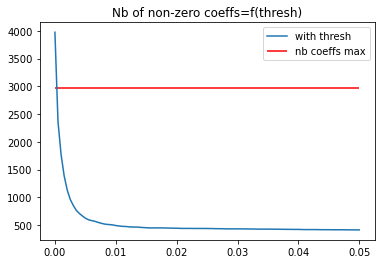

In [19]:
#multi-level

cD3th=pywt.threshold(cD3, thresh, 'soft')
cD2th=pywt.threshold(cD2, thresh, 'soft')
cD1th=pywt.threshold(cD1, thresh, 'soft')

coeffsth= cA3, cD3th, cD2th , cD1th

nbcoef1=sum(cA3!=0)+sum(cD3!=0)+sum(cD2!=0)+sum(cD1!=0)
nbcoef2=sum(cA3!=0)+sum(cD3th!=0)+sum(cD2th!=0)+sum(cD1th!=0)
print('sigma = ', 1)
print ('Number of non-zero coefficients before = ', nbcoef1)
print ('Number of non-zero coefficients after = ', nbcoef2)


def test_threshold_multi_level(ecg,sigma_min=0, sigma_max=0.05,level=3, family='db5'):
    coeffs = pywt.wavedec(ecg, family,level=level)
    nb_coeffs_non_zero=np.sum([sum(x!=0) for x in coeffs])
    plt.hlines(nb_coeffs_non_zero,sigma_min, sigma_max, label='nb coeffs max', color='red')
    
    sigma_space=np.linspace(sigma_min,sigma_max,100)
    nbcoef_after=[]
    
    for sigma in sigma_space:
        thresh = sigma*np.sqrt(2*np.log(LEN))
        coeffs = pywt.wavedec(ecg, family,level=level)
        new_coeffs=[pywt.threshold(c, thresh, 'soft') for c in coeffs[1:]]
        nbcoef_after.append(sum(coeffs[0]!=0) + np.sum([sum(x!=0) for x in new_coeffs]))

    plt.plot(sigma_space,nbcoef_after, label='with thresh')
    plt.title("Nb of non-zero coeffs=f(thresh)")
    plt.legend()
    plt.show()

test_threshold_multi_level(ecg_example)

### Reconstruction

longueur du nouveau signal 4112


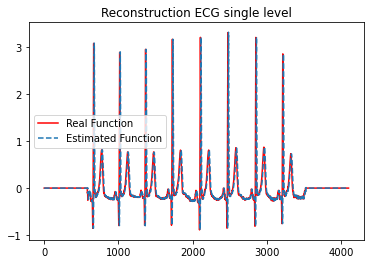

In [20]:
# single-level
single_level_ecg_rec= pywt.upcoef('a', cA, 'db5') + pywt.upcoef('d', cDth, 'db5')

print("longueur du nouveau signal",len(single_level_ecg_rec))

plt.plot(ecg_example,'red',label="Real Function")
plt.plot(single_level_ecg_rec[:LEN],'--',label="Estimated Function")
plt.title("Reconstruction ECG single level")
plt.legend()
plt.show()

longueur du nouveau signal 4096


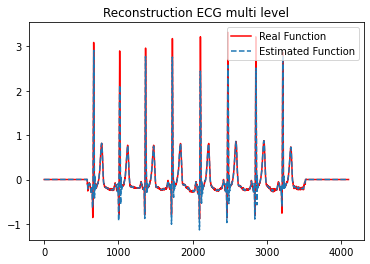

In [21]:
#multi-level

coeffsth= cA3, cD3th, cD2th , cD1th
multi_level_ecg_rec=pywt.waverec(coeffsth, 'db5')
print("longueur du nouveau signal",len(multi_level_ecg_rec))

plt.plot(ecg_example,'red',label="Real Function")
plt.plot(multi_level_ecg_rec,'--',label="Estimated Function")
plt.title("Reconstruction ECG multi level")
plt.legend()
plt.show()

### Critère de qualité : erreur quadratique

In [22]:
#single-level

single_level_error=np.mean((ecg_example-single_level_ecg_rec[:LEN])*(ecg_example-single_level_ecg_rec[:LEN]))
print("single_level_error = ",single_level_error)

single_level_error =  0.23732065873327146


In [23]:
#multi-level

multi_level_error=np.mean((ecg_example-multi_level_ecg_rec[:LEN])*(ecg_example-multi_level_ecg_rec[:LEN]))
print("multi_level_error = ", multi_level_error)

multi_level_error =  0.010065456248042092


## Général

In [24]:
def get_coeff_multi_level(ecg,sigma_threshold=1,type_threshold='soft',family='db5', level=3):
    coeffs = pywt.wavedec(ecg, family,level=level)
    thresh = sigma*np.sqrt(2*np.log(LEN))
    for i in range(1,len(coeffs)):
        coeffs[i]=pywt.threshold(coeffs[i], thresh, type_threshold)
    return coeffs

def reconstruct_signal(coeffsth,family='db5'):
    return pywt.waverec(coeffsth, family)

def error(real_ecg,rec_ecg):
    return np.mean((real_ecg-rec_ecg)*(real_ecg-rec_ecg))

## TEST (avec ECG du patient 0)

In [25]:
FAMILY_TO_TEST=['db4','db5','db6','db7','sym5','sym6','sym7','sym8']
LEVEL_TO_TEST=np.arange(2,9)

def test_general(ecg,sigma_threshold):

    f, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(20,25))

    for family in tqdm(FAMILY_TO_TEST):
        for type_threshold in ['soft','hard']:
            get_coeffs=[get_coeff_multi_level(ecg,sigma_threshold,type_threshold,family, level) for level in LEVEL_TO_TEST]
            new_signals=[reconstruct_signal(coeffsth,family) for coeffsth in get_coeffs]
            error_list=[error(ecg,rec_ecg) for rec_ecg in new_signals]
            ax1.plot(LEVEL_TO_TEST,error_list, label=family + " " +type_threshold)

            count_coeffs_non_zero=[np.sum([sum(c!=0) for c in coeffs]) for coeffs in get_coeffs]
            ax2.plot(LEVEL_TO_TEST,count_coeffs_non_zero, label=family + " " +type_threshold)

    ax1.set_title("Error = f(level) : sigma = "+str(sigma_threshold))
    ax1.legend(loc="best")
    ax2.set_title("Nb non zero coeffs = f(level) : sigma =  "+str(sigma_threshold))
    ax2.legend(loc="best")

    plt.show()


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.84it/s]


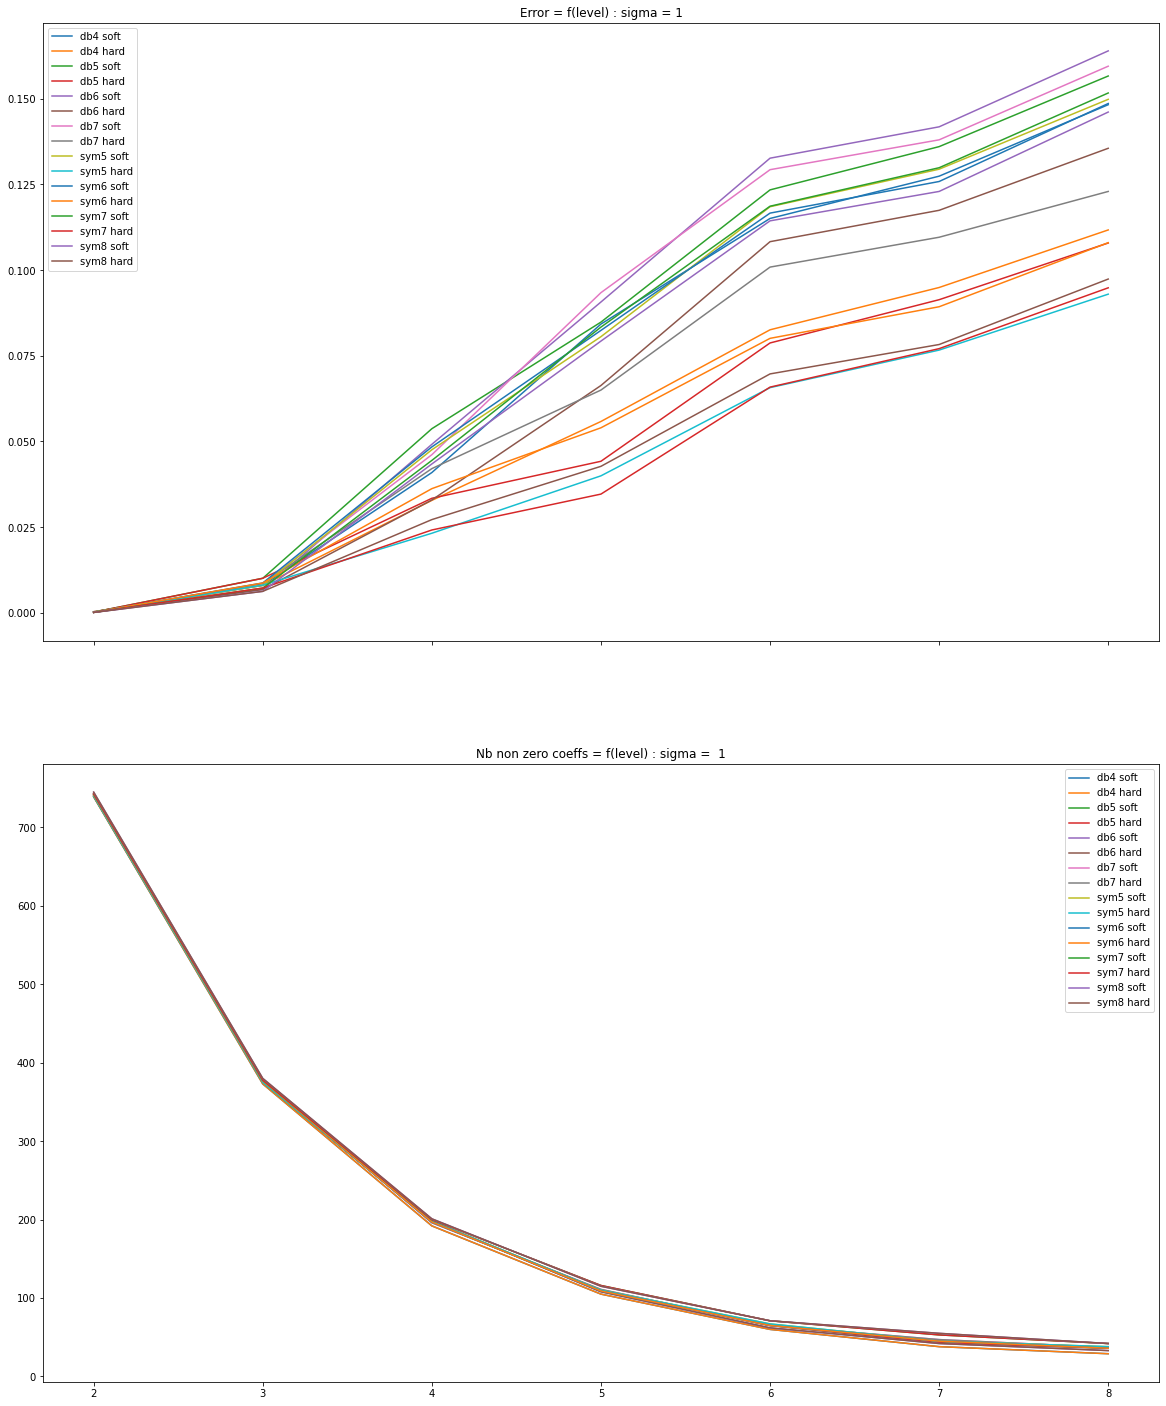

In [137]:
test_general(ecg_example,1)

BEST TRADEOFF

Level = 5
- 100 coefficients non nuls
- erreur inférieure à 0.050
- sym8 hard
- sym7 hard
- db5 hard
- db6 hard


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.60it/s]


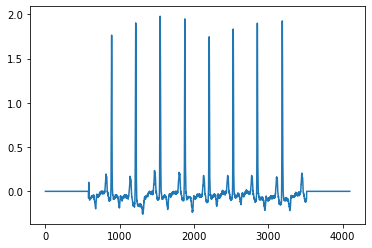

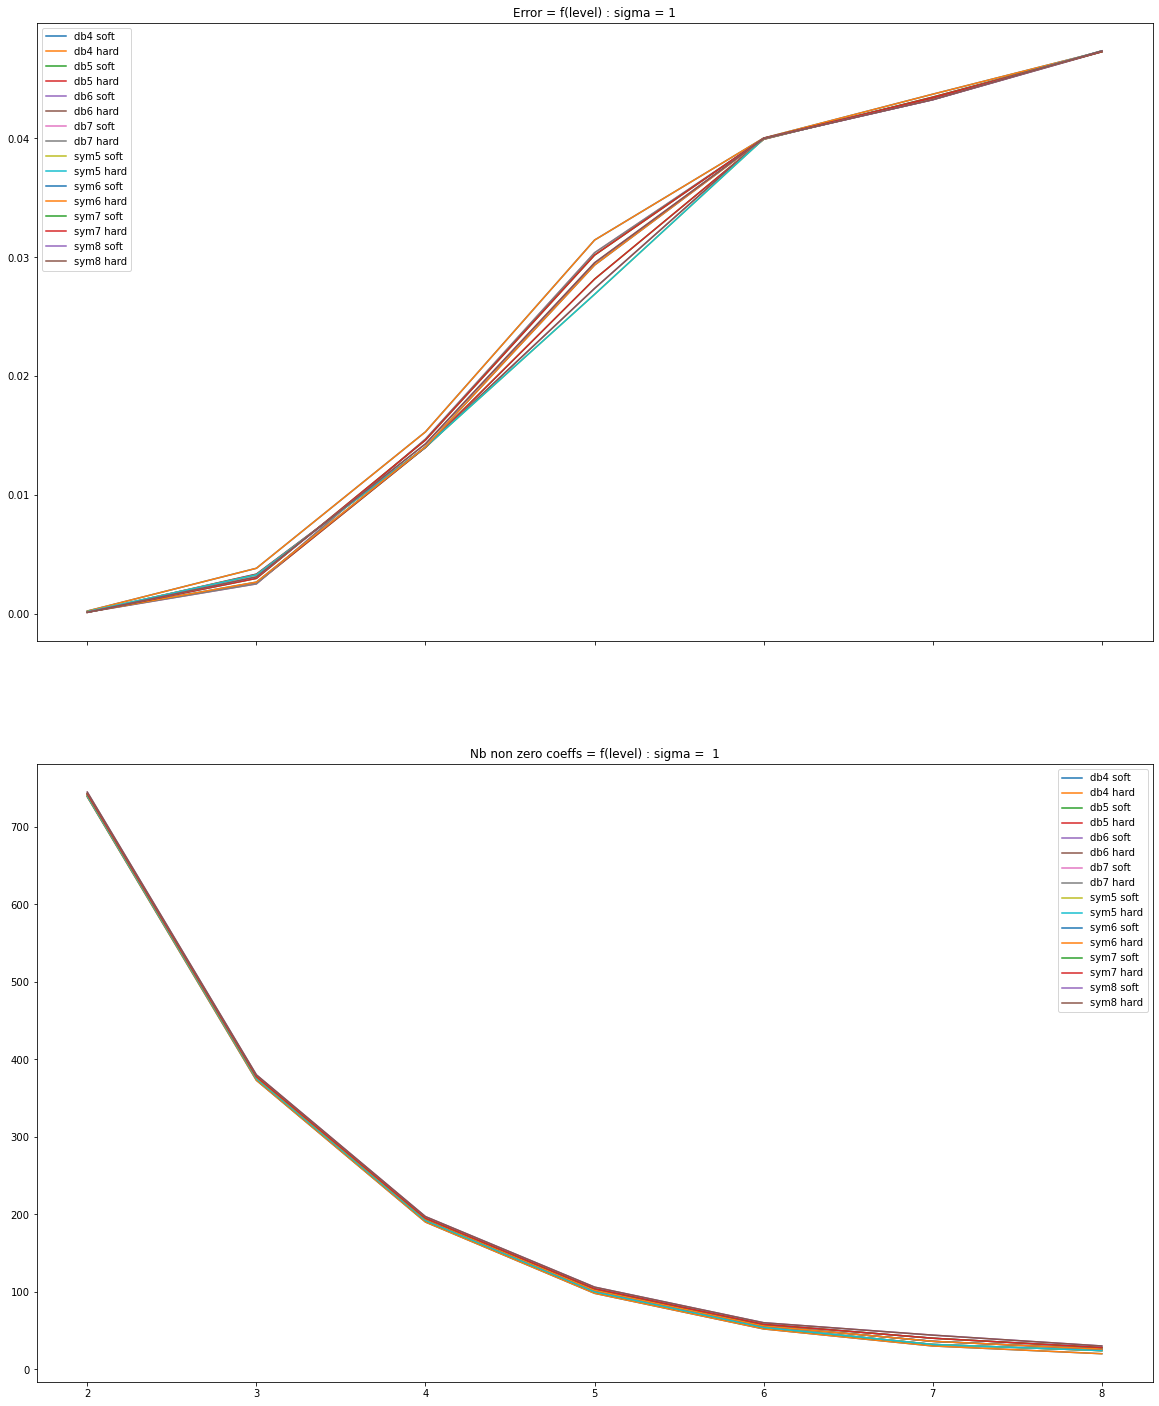

In [138]:
ecg_example1=get_ecg.get_ecg(patient_id=12)[0]
plt.plot(ecg_example1)

test_general(ecg_example1,1)

## TEST des 3 familles sur tous les ECG, level=8, soft, sigma=1 : erreur

In [33]:
def distribution_error(family, level, type_thre,sigma):
    error_range=[]
    nb_non_zero=[]
    for patient_id in tqdm(range(NB_PATIENT)):
        signal=get_ecg.get_ecg(patient_id=patient_id)
        get_coeffs=[get_coeff_multi_level(ecg,sigma,type_thre,family, level=level)  for ecg in signal]
        avg_count_coeffs_non_zero=np.mean([np.sum([sum(c!=0) for c in coeffs]) for coeffs in get_coeffs])
        mean_error=np.mean([error(signal[i],reconstruct_signal(get_coeffs[i], family)) for i in range(12)])
        nb_non_zero.append(avg_count_coeffs_non_zero)
        error_range.append(mean_error)
    return error_range, nb_non_zero

In [34]:
error_db5, nb_non_zero_db5=distribution_error('db5',5,'hard',1)

100%|████████████████████████████████████████████████████████████████████████████████| 827/827 [06:07<00:00,  2.25it/s]


In [ ]:
error_db6, nb_non_zero_db6=distribution_error('db6',5,'hard',1)

In [40]:
error_db5_soft, nb_non_zero_db5_soft=distribution_error('db5',5,'soft',1)

100%|████████████████████████████████████████████████████████████████████████████████| 827/827 [06:19<00:00,  2.18it/s]


In [ ]:
error_sym7, nb_non_zero_sym7=distribution_error('sym7',5,'hard',1)

In [52]:
error_sym8, nb_non_zero_sym8=distribution_error('sym8',5,'hard',1)

100%|████████████████████████████████████████████████████████████████████████████████| 827/827 [06:05<00:00,  2.26it/s]


Hard or soft threshold ? Less error with hard, with the same number of non zero coeffs

moyenne error soft db5 :  0.048429627801519236
moyenne error hard db5 :  0.03722893005275781


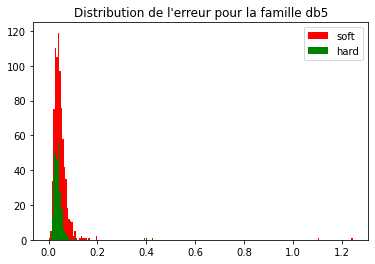

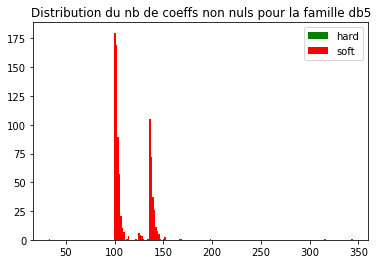

In [61]:
print("moyenne error soft db5 : ",np.mean(error_db5_soft))
print("moyenne error hard db5 : ",np.mean(error_db5))

plt.hist(error_db5_soft, bins=200, label='soft',color='red')
plt.hist(error_db5, bins=200, label='hard', color='green')
plt.title("Distribution de l'erreur pour la famille db5")
plt.legend()
plt.show()

plt.hist(nb_non_zero_db5, bins=200,label='hard', color='green')
plt.hist(nb_non_zero_db5_soft, bins=200, label='soft',color='red')
plt.title("Distribution du nb de coeffs non nuls pour la famille db5")
plt.legend()
plt.show()

Symlet or Daubechy ? Less error for sym but more non zero coeffs

moyenne error hard sym8 :  0.03526763402117297
moyenne error hard db5 :  0.03722893005275781
moyenne nb_non_zero_coeffs hard sym8 :  121.17110036275696
moyenne nb_non_zero_coeffs hard db5 :  115.03950020153162


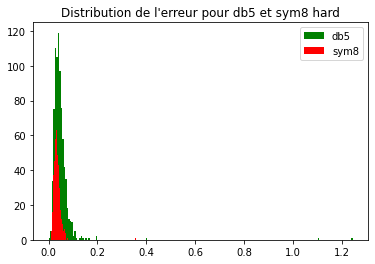

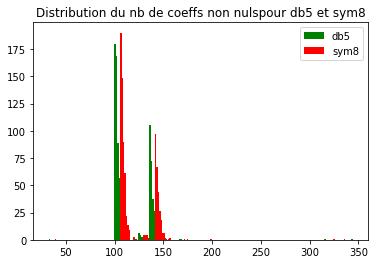

In [134]:
print("moyenne error hard sym8 : ",np.mean(error_sym8))
print("moyenne error hard db5 : ",np.mean(error_db5))
print("moyenne nb_non_zero_coeffs hard sym8 : ",np.mean(nb_non_zero_sym8))
print("moyenne nb_non_zero_coeffs hard db5 : ",np.mean(nb_non_zero_db5))

plt.hist(error_db5_soft, bins=200, label='db5',color='green')
plt.hist(error_sym8, bins=200, label='sym8', color='red')
plt.title("Distribution de l'erreur pour db5 et sym8 hard")
plt.legend()
plt.show()

plt.hist(nb_non_zero_db5, bins=200,label='db5', color='green')
plt.hist(nb_non_zero_sym8, bins=200, label='sym8',color='red')
plt.title("Distribution du nb de coeffs non nulspour db5 et sym8")
plt.legend()
plt.show()

# 2. Decomposition Fourier

In [10]:
import read_ecg

In [29]:
sigma=1
ECG = table_ecg[:, :, 0]
nouv_ECG=np.array([read_ecg.symetrize_bounds(ecg) for ecg in ECG])
np.shape(nouv_ECG)

(827, 4097)

In [30]:
fourier=np.fft.fft(nouv_ECG, axis=1)

In [32]:
threshold = sigma * np.sqrt(2 * np.log(LEN))
for freq_list in fourier:
    freq_list[np.abs(freq_list) < threshold] = 0

In [33]:
np.shape(fourier)

(827, 4097)

# TRASH

In [57]:
a=np.array([[[0,1],[2,0]],[[3,4],[2,0]]])
b=np.concatenate(a,axis=1)

In [60]:
b

array([[0, 1, 3, 4],
       [2, 0, 2, 0]])

In [59]:
np.sum(np.abs(b)>0.0001,axis=1)

array([3, 2])

In [64]:
CMAP = plt.get_cmap("Set1")

In [65]:
CMAP

In [66]:
import pandas as pd

In [101]:
#confirmation sur une maladie
CMAP = plt.get_cmap("Set1")
DISEASE_DIC = {0: "1dAVb",
               1: "Rien"}
COLOR_DIC = {k: CMAP(k - 2) if k != 0 else CMAP(11) for k, v in DISEASE_DIC.items()}
LABELS = [DISEASE_DIC[c] for c in range(2)]

ANNOTATIONS_CSV=np.genfromtxt("./data/annotations/dnn.csv", delimiter=',')[1:,1:]
ANNOTATIONS_CSV_pd=pd.read_csv("./data/annotations/dnn.csv", delimiter=',')

In [105]:
colors = [COLOR_DIC[y] for y in ANNOTATIONS_CSV_pd["1dAVb"]]

In [96]:
color_1dAVb=[CMAP(11) for value in 

0      0
1      0
2      0
3      0
4      0
      ..
822    0
823    0
824    0
825    0
826    1
Name: 1dAVb, Length: 827, dtype: int64

In [84]:
res=[0,0,1,0,0,0]
colors=[COLOR_DIC[i] for i in range(6) if res[i]>0]

KeyError: 2

In [78]:
ANNOTATIONS_CSV

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [106]:
series={"moyenne":res}
pd.DataFrame(series)

,moyenne
0,0
1,0
2,1
3,0
4,0
5,0


In [138]:
DISEASE_DIC = {0: "Non malade",
               1: "1dAVb",
               2: "RBBB",
               3: "LBBB",
               4: "SB",
               5: "AF",
               6: "ST"
               }
DISEASE_DIC.values()

dict_values(['Non malade', '1dAVb', 'RBBB', 'LBBB', 'SB', 'AF', 'ST'])